# Sınıflandırma

*Denetimli* makine öğrenimi teknikleri, bir modelin bir dizi *özellik* üzerinde çalışacak ve önceden bilinen bazı etiket değerlerini içeren bir veri kümesini kullanarak bir *etiketi* tahmin edecek şekilde eğitilmesini içerir. Bu fonksiyonu şöyle düşünebilirsiniz, burada ***y*** tahmin etmek istediğimiz etiketi ve ***X*** modelin onu tahmin etmek için kullandığı özellik vektörünü temsil eder.

$$y = f([x_1, x_2, x_3, ...])$$


*Sınıflandırma*, bir dizi olası sınıfın her birine ait gözlenen vakanın olasılığını hesaplayan bir etiketi (***y***) tahmin etmek ve uygun bir etiketi tahmin etmek için özellikleri (fonksiyonumuzdaki ***x*** değerleri) kullanmak üzere bir modeli eğittiğiniz bir denetimli makine öğrenimi biçimidir. En basit sınıflandırma biçimi, etiketin iki sınıftan birini temsil eden 0 veya 1 olduğu *ikili* sınıflandırmadır; örneğin, "Doğru" veya "Yanlış"; "Dahili veya harici"; "Karlı" veya "Karsız"; ve benzeri.

## İkili Sınıflandırma

Bu not defterinde, modelin iki sınıftan birine ait bir etiketi tahmin etmesi gereken bir *ikili sınıflandırma* örneğine odaklanacağız. Bu alıştırmada, bazı tıbbi verilere dayanarak bir hastanın diyabet için test edilip edilmeyeceğini tahmin etmek için bir ikili sınıflandırıcıyı eğiteceğiz.

> **Alıntı**: Bu alıştırmada kullanılan diyabet veri seti, Ulusal Diyabet ve Sindirim ve Böbrek Hastalıkları Enstitüsü tarafından orijinal olarak toplanan verilere dayanmaktadır.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


Bu veriler, diyabet için test edilmiş bazı hastalar hakkında teşhis bilgilerinden oluşur. Gerekirse sağa kaydırın ve veri kümesindeki (**Diyabetik**) son sütunun diyabet testi negatif çıkan hastalar için ***0*** ve testi pozitif çıkan hastalar için ***1*** değerini içerdiğine dikkat edin. Bu, tahmin etmesi için modelimizi eğiteceğimiz etikettir; diğer sütunların çoğu (**Hamilelikler**,**PlazmaGlikoz**,**DiyastolikKan Basıncı** vb.) **Diyabetik** etiketini tahmin etmek için kullanacağımız özelliklerdir.

Özellikleri etiketlerden ayıralım - özelliklere ***X*** ve etikete **y** diyeceğiz

In [5]:
# Ayrı özellikler ve etiketler
features = ["Pregnancies", "PlasmaGlucose", "DiastolicBloodPressure", "TricepsThickness", "SerumInsulin", "BMI", "DiabetesPedigree", "Age"]
label = "Diabetic"

X, y = df[features].values, df[label].values

for n in range(0,4):
    print("Patient", str(n+1), "\n Features: ", list(X[n]), "\n Label: ", y[n])

Patient 1 
 Features:  [0.0, 171.0, 80.0, 34.0, 23.0, 43.50972593, 1.213191354, 21.0] 
 Label:  0
Patient 2 
 Features:  [8.0, 92.0, 93.0, 47.0, 36.0, 21.24057571, 0.158364981, 23.0] 
 Label:  0
Patient 3 
 Features:  [7.0, 115.0, 47.0, 52.0, 35.0, 41.51152348, 0.079018568, 23.0] 
 Label:  0
Patient 4 
 Features:  [9.0, 103.0, 78.0, 25.0, 304.0, 29.58219193, 1.282869847, 43.0] 
 Label:  1


Şimdi her bir etiket değeri için özellik dağılımlarını karşılaştıralım.

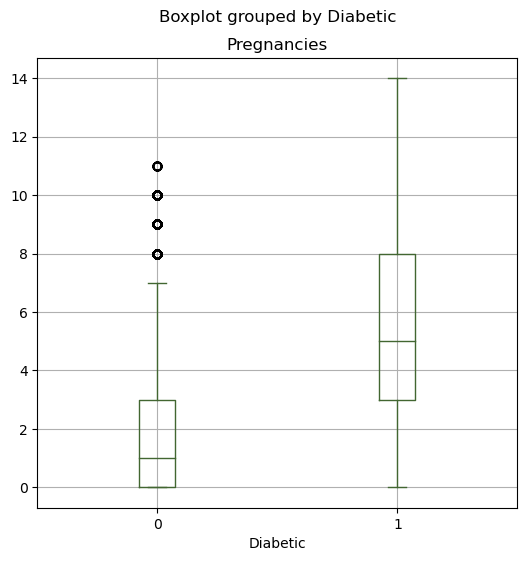

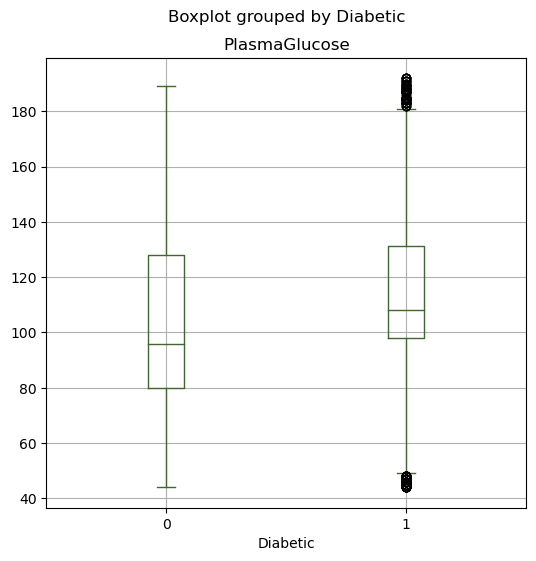

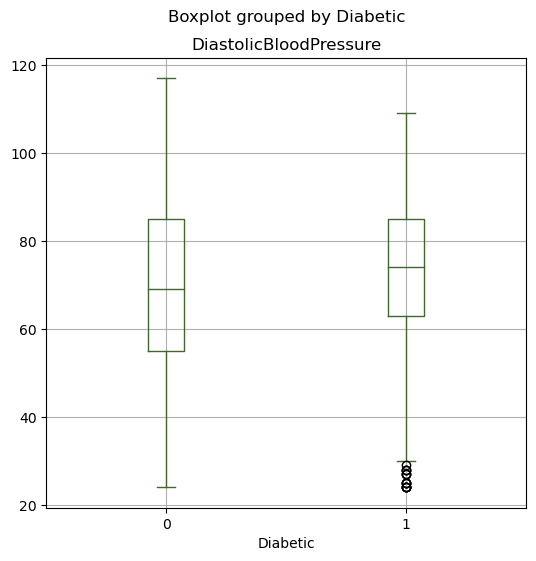

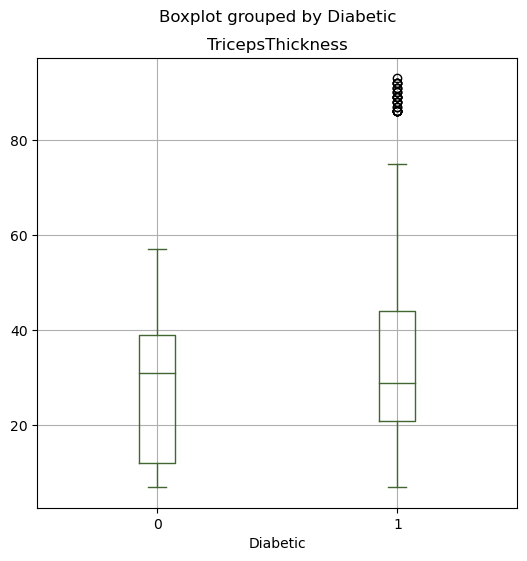

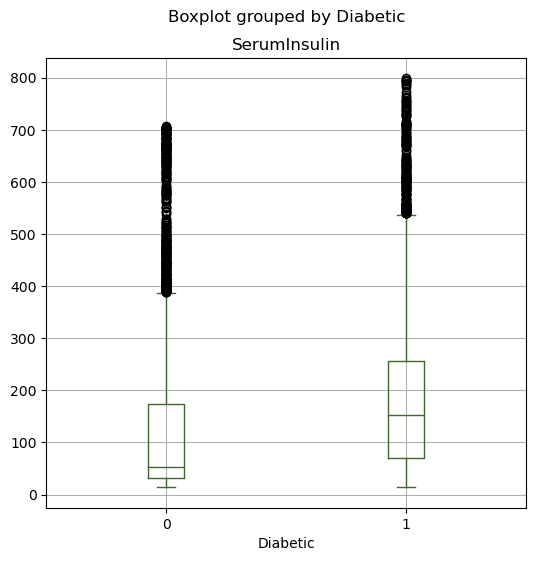

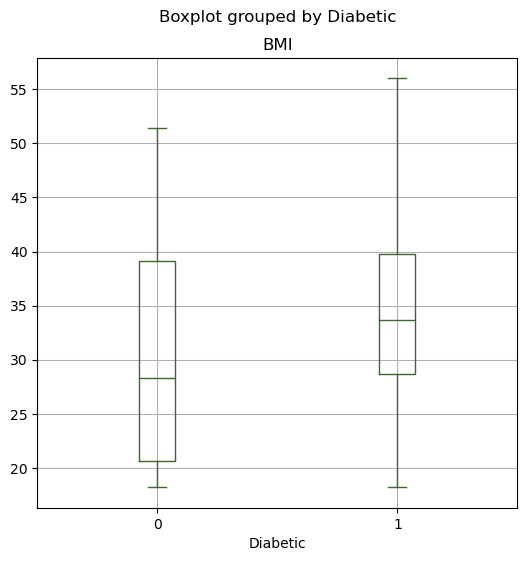

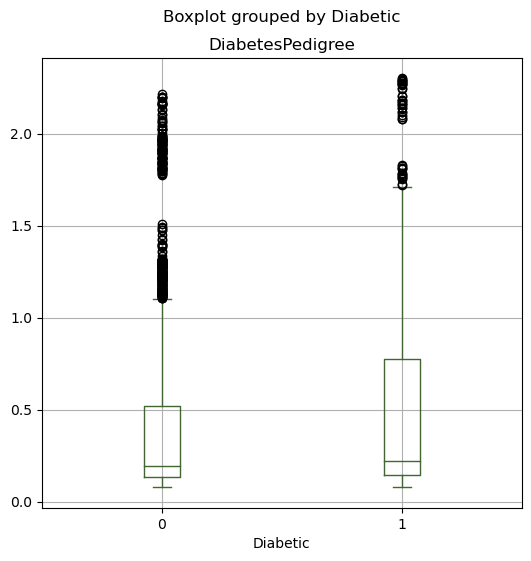

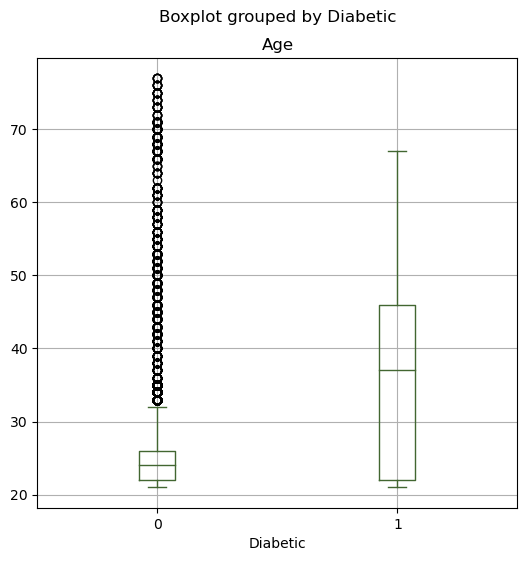

In [6]:
for col in features:
    df.boxplot(column=col, by="Diabetic", figsize=(6,6), color="#426631")
    plt.title(col)
plt.show()    

Bazı özellikler için, her bir etiket değerinin dağılımında gözle görülür bir fark vardır. Özellikle **Hamilelikler** ve **Yaş**, diyabetik hastalarda diyabetik olmayan hastalara göre belirgin şekilde farklı dağılımlar göstermektedir. Bu özellikler, bir hastanın diyabetik olup olmadığını tahmin etmeye yardımcı olabilir.

### Verileri bölme

Veri setimiz, etiket için bilinen değerleri içerir, dolayısıyla bunu, özellikler ile etiket değeri arasında istatistiksel bir ilişki bulması için bir sınıflandırıcıyı eğitmek için kullanabiliriz; ama modelimizin iyi olup olmadığını nasıl bileceğiz? Eğitilmemiş yeni verilerle kullandığımızda doğru tahmin edeceğini nereden bileceğiz? Bilinen etiket değerlerine sahip büyük bir veri kümemiz olduğu gerçeğinden faydalanabilir, bunun yalnızca bir kısmını modeli eğitmek için kullanabilir ve eğitilen modeli test etmek için bir kısmını tutabiliriz - tahmin edilen etiketleri test setindeki zaten bilinen etiketlerle karşılaştırmamızı sağlar.

Python'da **scikit-learn** paketi, bir makine öğrenimi modeli oluşturmak için kullanabileceğimiz çok sayıda işlev içerir - eğitim ve test verilerinin istatistiksel olarak rastgele bir bölümünü elde etmemizi sağlayan **train_test_split** işlevi dahil. Bunu, verileri eğitim için %70'e bölmek ve test için %30'u tutmak için kullanacağız.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [10]:
print(f"Training cases: {X_train.shape[0]} \nTest cases: {X_test.shape[0]}")

Training cases: 10500 
Test cases: 4500


### İkili Sınıflandırma Modelini Eğitme ve Değerlendirme
Tamam, şimdi eğitim özelliklerini (**X_train**) eğitim etiketlerine (**y_train**) uydurarak modelimizi eğitmeye hazırız. Modeli eğitmek için kullanabileceğimiz çeşitli algoritmalar var. Bu örnekte, (adına rağmen) sınıflandırma için köklü bir algoritma olan *Lojistik Regresyon*'u kullanacağız. Eğitim özelliklerine ve etiketlerine ek olarak bir *düzenleme* parametresi ayarlamamız gerekecek. Bu, örneklemdeki herhangi bir önyargıyı ortadan kaldırmak ve modeli eğitim verilerine *fazla uydurmaktan* kaçınarak modelin iyi genelleştirilmesine yardımcı olmak için kullanılır.

> **Not**: Makine öğrenimi algoritmalarının parametrelerine genellikle *hiperparametreler* denir (bir veri bilimcisi için *parametreler* verinin kendisindeki değerlerdir - *hiperparametreler* verilerden harici olarak tanımlanır!)

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
reg = 0.01
# Lojistik regresyonda, reg genellikle düzenlileştirme (regularization) parametresini temsil eder ve 
# modelde aşırı uyumunu (overfitting) kontrol etmek için kullanılır.

model = LogisticRegression(C=1/reg, solver="liblinear")
# C parametresi düzenlileştirme kuvvetinin tersidir, bu nedenle C=1/reg ifadesi, 
# düzenlileştirme kuvvetinin 1/0.01 yani 100 olarak ayarlanacağı anlamına gelir. 
# C değeri ne kadar yüksek olursa, düzenlileştirme kuvveti o kadar zayıf olur.
model.fit(X_train, y_train)
print(model)

LogisticRegression(C=100.0, solver='liblinear')


Artık modeli eğitim verilerini kullanarak eğittik, geride tuttuğumuz test verilerini ne kadar iyi tahmin ettiğini değerlendirmek için kullanabiliriz. Yine **scikit-learn** bunu yapmamıza yardımcı olabilir. Test setimizin etiketlerini tahmin etmek için modeli kullanarak başlayalım ve tahmin edilen etiketleri bilinen etiketlerle karşılaştıralım:

In [13]:
predictions = model.predict(X_test)
print("Predicted labels: ", predictions)
print("Actual labels: ", y_test)

Predicted labels:  [0 0 0 ... 0 1 0]
Actual labels:  [0 0 1 ... 1 1 1]


Etiket dizileri not defteri çıktısında görüntülenemeyecek kadar uzun olduğundan yalnızca birkaç değeri karşılaştırabiliriz. Tahmin edilen ve gerçek etiketlerin hepsini yazdırmış olsak bile, modeli değerlendirmek için bunu mantıklı bir yol haline getirmek için çok fazla etiket var. Neyse ki **scikit-learn**'in elinde birkaç numara daha var ve modeli değerlendirmek için kullanabileceğimiz bazı ölçümler sağlıyor.

Yapmak isteyebileceğiniz en bariz şey tahminlerin *doğruluğunu* kontrol etmektir - basit bir ifadeyle, model etiketlerin ne kadarını doğru tahmin etti?

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
accuracy_score(y_test, predictions)

0.7893333333333333

Doğruluk, ondalık bir değer olarak döndürülür - 1,0 değeri, modelin tahminlerin %100'ünü doğru yaptığı anlamına gelir; 0.0'lık bir doğruluk oldukça işe yaramazken!

# Sınıflandırma Metrikleri

## İkili sınıflandırıcılar için alternatif metrikler

Doğruluk, değerlendirilmesi gereken makul bir ölçü gibi görünür (ve bir dereceye kadar öyledir), ancak bir sınıflandırıcının doğruluğundan çok fazla sonuç çıkarma konusunda dikkatli olmanız gerekir. Bunun sadece kaç vakanın doğru tahmin edildiğinin bir ölçüsü olduğunu unutmayın. Nüfusun sadece %3'ünün şeker hastası olduğunu varsayalım. Her zaman sadece 0'ı tahmin eden bir sınıflandırıcı oluşturabilirsiniz ve bu %97 doğru olur - ancak diyabetli hastaları belirlemede pek yardımcı olmaz!

Neyse ki, modelimizin nasıl performans gösterdiği hakkında biraz daha bilgi veren başka ölçümler de var. Scikit-Learn, tek başına ham doğruluktan daha fazla içgörü sağlayan bir *sınıflandırma raporu* oluşturma becerisini içerir.

Başlamak için en basit yerlerden biri bir sınıflandırma raporudur.

In [16]:
from sklearn.metrics import classification_report

In [18]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      2986
           1       0.72      0.60      0.66      1514

    accuracy                           0.79      4500
   macro avg       0.77      0.74      0.75      4500
weighted avg       0.78      0.79      0.78      4500



Sınıflandırma raporu, her sınıf için aşağıdaki metrikleri içerir (0 ve 1)

> başlık satırının değerlerle aynı hizada olmayabileceğini unutmayın!

* *Precision(Kesinlik)*: Modelin bu sınıf için yaptığı tahminlerin ne kadarı doğru çıktı?
* *Recall(Hatırlama)*: Test veri kümesindeki bu sınıfın tüm örneklerinden model kaç tanesini tanımladı?
* *F1-Score(F1 Puanı)*: Hem kesinliği hem de geri çağırmayı hesaba katan ortalama bir ölçüm.
* *Support(Destek)*: Test veri setinde bu sınıfın kaç örneği var?

Sınıflandırma raporu ayrıca, her sınıfın vaka sayısındaki dengesizliğe izin veren ağırlıklı bir ortalama da dahil olmak üzere, bu ölçütler için ortalamaları da içerir.

Bu bir *ikili* sınıflandırma problemi olduğundan, ***1*** sınıfı *olumlu* kabul edilir, kesinliği ve hatırlaması özellikle ilgi çekicidir - bunlar aslında şu soruları yanıtlar:

- Modelin diyabetik olduğunu tahmin ettiği tüm hastalardan kaç tanesi gerçekten diyabetik?
- Model gerçekten diyabetik olan tüm hastalardan kaç tanesini tanımladı?

scikit-learn'deki **precision_score** ve **recall_score** metriklerini kullanarak (varsayılan olarak bir ikili sınıflandırma modeli varsayar) bu değerleri kendi başınıza alabilirsiniz.

In [19]:
from sklearn.metrics import precision_score, recall_score

In [20]:
print("Overall Precision: ", precision_score(y_test, predictions))
print("Overall Recall: ", recall_score(y_test, predictions))

Overall Precision:  0.7242472266244057
Overall Recall:  0.6036988110964333


Kesinlik ve geri çağırma ölçütleri, dört olası tahmin sonucundan elde edilir:
* *Gerçek Pozitifler*: Öngörülen etiket ve gerçek etiketin her ikisi de 1'dir.
* *Yanlış Pozitif*: Öngörülen etiket 1'dir, ancak gerçek etiket 0'dır.
* *Yanlış Negatifler*: Öngörülen etiket 0'dır, ancak gerçek etiket 1'dir.
* *Gerçek Negatifler*: Öngörülen etiket ve gerçek etiketin her ikisi de 0'dır.

Bu ölçümler genellikle test seti için tablo haline getirilir ve aşağıdaki biçimi alan bir *karmaşıklık matrisi* olarak birlikte gösterilir:

<table style="border: 1px solid black;">
    <tr style="border: 1px solid black;">
        <td style="border: 1px solid black;color: black;" bgcolor="lightgray">TN</td><td style="border: 1px solid black;color: black;" bgcolor="white">FP</td>
    </tr>
    <tr style="border: 1px solid black;">
        <td style="border: 1px solid black;color: black;" bgcolor="white">FN</td><td style="border: 1px solid black;color: black;" bgcolor="lightgray">TP</td>
    </tr>
</table>

*Doğru* tahminlerin sol üstten sağ alta çapraz bir çizgi oluşturduğuna dikkat edin - model iyiyse bu rakamlar *yanlış* tahminlerden önemli ölçüde yüksek olmalıdır.

Python'da, eğitimli bir sınıflandırıcı için şu değerleri bulmak üzere **sklearn.metrics.confusion_matrix** işlevini kullanabilirsiniz:

In [21]:
from sklearn.metrics import confusion_matrix

In [23]:
print(confusion_matrix(y_test, predictions))

[[2638  348]
 [ 600  914]]


Şimdiye kadar, modelden gelen tahminleri 1 veya 0 sınıf etiketi olarak değerlendirdik. Aslında işler bundan biraz daha karmaşık. Lojistik regresyon gibi istatistiksel makine öğrenimi algoritmaları *olasılığa* dayalıdır; bu nedenle, bir ikili sınıflandırıcı tarafından gerçekte tahmin edilen, etiketin doğru olma olasılığı (**P(y)**) ve etiketin yanlış olma olasılığıdır (1 - **P(y)**). Öngörülen etiketin 1 (*P(y) > 0,5*) veya 0 (*P(y) <= 0,5*) olup olmadığına karar vermek için 0,5'lik bir eşik değeri kullanılır. Her durum için olasılık çiftlerini görmek üzere **predict_proba** yöntemini kullanabilirsiniz:

In [24]:
y_scores = model.predict_proba(X_test)
print(y_scores)

[[0.81657116 0.18342884]
 [0.9630332  0.0369668 ]
 [0.80872619 0.19127381]
 ...
 [0.60692458 0.39307542]
 [0.10656641 0.89343359]
 [0.63859127 0.36140873]]


Bir tahmini 1 veya 0 olarak puanlama kararı, tahmin edilen olasılıkların karşılaştırıldığı eşiğe bağlıdır. Eşiği değiştirirsek tahminleri etkiler; ve dolayısıyla karışıklık matrisindeki metrikleri değiştirin. Bir sınıflandırıcıyı değerlendirmenin yaygın bir yolu, bir dizi olası eşik için *gerçek pozitif oranı* (hatırlamanın başka bir adıdır) ve *yanlış pozitif oranını* incelemektir. Bu oranlar daha sonra *alınan operatör özelliği (ROC) tablosu* olarak bilinen bir tablo oluşturmak için tüm olası eşiklere karşı çizilir, şöyle:

In [25]:
from sklearn.metrics import roc_curve

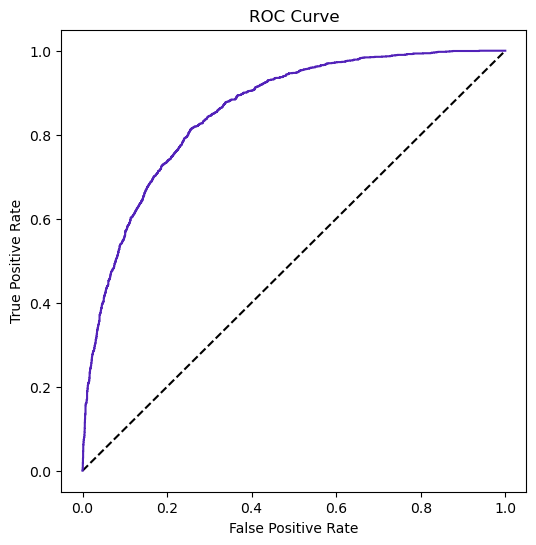

In [27]:
# ROC eğrisini hesaplayın
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# ROC eğrisi çizin
fig = plt.figure(figsize=(6,6))
# Çapraz %50 çizgisini çizin
plt.plot([0, 1], [0, 1], "k--")
# Modelimiz tarafından elde edilen FPR ve TPR'yi çizin
plt.plot(fpr, tpr, color="#5222b9")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

ROC şeması, 0 ile 1 arasındaki farklı eşik değerleri için doğru ve yanlış pozitif oranların eğrisini gösterir. Mükemmel bir sınıflandırıcının, sol tarafta düz yukarı ve tepede düz giden bir eğrisi olacaktır. Tablodaki çapraz çizgi, 50/50 rasgele tahminle doğru tahmin yapma olasılığını temsil eder; bu nedenle, eğrinin bundan daha yüksek olmasını istediğiniz açıktır (veya modeliniz sadece tahmin etmekten daha iyi değildir!).

Eğrinin altındaki alan (AUC), modelin genel performansını ölçen 0 ile 1 arasında bir değerdir. Bu değer 1'e ne kadar yakınsa model o kadar iyidir. Bir kez daha, scikit-Learn bu ölçümü hesaplamak için bir işlev içerir.

In [28]:
from sklearn.metrics import roc_auc_score

In [29]:
auc = roc_auc_score(y_test, y_scores[:,1])
print("AUC: ", auc)

AUC:  0.8568444904932839


### Bir ardışık düzende ön işleme gerçekleştirin

Bu durumda, ROC eğrisi ve onun AUC'si, modelin rastgele bir tahminden daha iyi performans gösterdiğini gösteriyor ki bu, verilerin çok az ön işlemesini yaptığımız düşünülürse fena sayılmaz.

Uygulamada, algoritmanın kendisine bir model uydurmasını kolaylaştırmak için verilerde bazı ön işlemler gerçekleştirmek yaygın bir uygulamadır. Verilerinizi modellemeye hazırlamak için gerçekleştirebileceğiniz çok çeşitli ön işleme dönüşümleri vardır, ancak kendimizi birkaç genel teknikle sınırlayacağız:

- Sayısal özellikleri aynı ölçekte olacak şekilde ölçeklendirme. Bu, büyük değerlere sahip özelliklerin tahminleri orantısız bir şekilde etkileyen katsayılar üretmesini engeller.
- Kategorik değişkenleri kodlama. Örneğin, bir *bir etkin kodlama* tekniği kullanarak, olası her kategori değeri için ayrı ikili (doğru/yanlış) özellikler oluşturabilirsiniz.

Bu ön işleme dönüşümlerini uygulamak için *pipelines* adlı bir Scikit-Learn özelliğini kullanacağız. Bunlar, bir algoritma ile biten bir dizi ön işleme adımı tanımlamamızı sağlar. Daha sonra modelin, regresyon algoritmasının yanı sıra tüm ön işleme adımlarını kapsaması için tüm pipelineı verilere sığdırabilirsiniz. Bu yararlıdır, çünkü yeni verilerden değerleri tahmin etmek için modeli kullanmak istediğimizde, aynı dönüşümleri uygulamamız gerekir (eğitim verileriyle kullanılan aynı istatistiksel dağılımlara ve kategori kodlamalarına dayalı olarak).

>**Not**: *pipeline* terimi, makine öğreniminde yaygın olarak kullanılır ve genellikle çok farklı anlamlara gelir! Bu bağlamda, Scikit-Learn'deki ardışık düzen nesnelerine atıfta bulunmak için kullanıyoruz, ancak başka bir yerde başka bir anlama gelmek için kullanıldığını görebilirsiniz.

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [31]:
numeric_features = [0,1,2,3,4,5,6]
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_features = [7]
categorical_transformer = Pipeline(steps=[("onehat", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                               ("cat", categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("logregressor", LogisticRegression(C=1/reg, solver="liblinear"))])

model = pipeline.fit(X_train, y_train)
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('logregressor',
                 LogisticRegression(C=100.0, solver='liblinear'))])


Ardışık düzen, ön işleme adımlarının yanı sıra model eğitimini de kapsar.

Test setimizin etiketlerini tahmin etmek için bu ardışık düzen tarafından eğitilen modeli kullanalım ve performans ölçümlerini daha önce oluşturduğumuz temel modelle karşılaştıralım.

Confusion Matrix:
 [[2667  319]
 [ 406 1108]] 

Accuracy: 0.8388888888888889
Overall Precision: 0.7764540995094604
Overall Recall: 0.7318361955085865
AUC: 0.9202440539337694


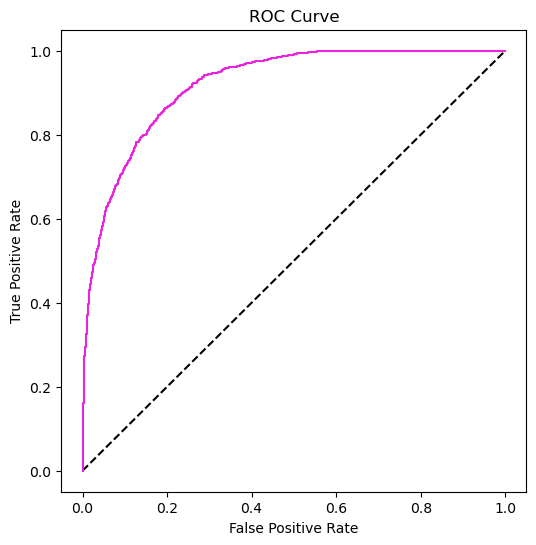

In [33]:
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)

cm = confusion_matrix(y_test, predictions)
print ("Confusion Matrix:\n",cm, "\n")
print("Accuracy:", accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test, y_scores[:,1])
print("AUC: " + str(auc))

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

fig = plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color = "#ea24dc")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

Sonuçlar biraz daha iyi görünüyor, bu nedenle verilerin önceden işlenmesi açıkça bir fark yarattı.

### Farklı bir algoritma deneyin

Şimdi farklı bir algoritma deneyelim. Daha önce *doğrusal* bir algoritma olan bir lojistik regresyon algoritması kullanmıştık. Deneyebileceğimiz pek çok sınıflandırma algoritması vardır, bunlar arasında:

- **Destek Vektör Makinesi algoritmaları**: Sınıfları ayıran bir *hiperdüzlem* tanımlayan algoritmalar.
- **Ağaç tabanlı algoritmalar**: Bir tahmine ulaşmak için karar ağacı oluşturan algoritmalar
- **Toplu algoritmalar**: Genelleştirilebilirliği iyileştirmek için birden çok temel algoritmanın çıktılarını birleştiren algoritmalar.

Bu kez, daha önce olduğu gibi aynı ön işleme adımlarını kullanacağız, ancak modeli birden çok rasgele karar ağacının çıktılarını birleştiren *Random Forest* adlı bir *topluluk* algoritması kullanarak eğiteceğiz.

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("logregressor", RandomForestClassifier(n_estimators=100))])
model = pipeline.fit(X_train, y_train)
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('logregressor', RandomForestClassifier())])


Yeni model için performans metriklerine bir göz atalım.

Confusion Matrix:
 [[2852  134]
 [ 181 1333]] 

Accuracy: 0.93
Overall Precision: 0.9086571233810498
Overall Recall: 0.880449141347424
AUC: 0.9819415971141416


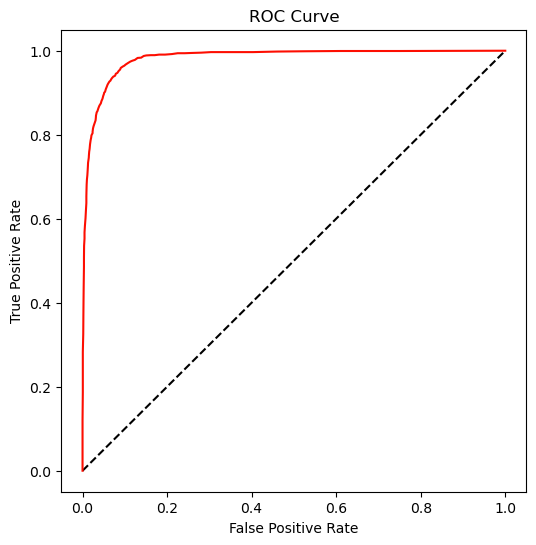

In [36]:
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)

cm = confusion_matrix(y_test, predictions)
print ("Confusion Matrix:\n",cm, "\n")
print("Accuracy:", accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test, y_scores[:,1])
print("AUC: " + str(auc))

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

fig = plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color = "#fd0e01")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

Bu daha iyi görünüyor!

In [37]:
X_new = np.array([[2,180,74,24,21,23.9091702,1.488172308,22]])
print ('New sample: {}'.format(list(X_new[0])))

pred = model.predict(X_new)
print('Predicted class is {}'.format(pred[0]))

New sample: [2.0, 180.0, 74.0, 24.0, 21.0, 23.9091702, 1.488172308, 22.0]
Predicted class is 1
